In [157]:
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
from jax import grad
from jax import jit, grad, jacfwd, jacrev
from jax.lax import fori_loop
from jax import jit
from functools import partial

import math


import scipy 

import matplotlib.pyplot as plt
import plotly.graph_objects as go

%matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]
plt.style.use('default')
plt.rcParams['lines.markersize'] = 8
plt.rcParams.update({'font.size': 12})


from tqdm import tqdm
import time

from jax.config import config
config.update("jax_enable_x64", True)

import sys
sys.path.append("..")

from Ours import Ours
from FD import FD
from Functions import Quadratic, PyCutestGetter, Ackley
from RBF import RBF
from utils import mse_sensitivity, get_rbfs


from DynamicalSystems import Laser, LaserFull, Monod, invert_Laser_params, Cancer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compare against true Hessian (so optimal benefit we can obtain) to some coarse model. 

# Laser

In [29]:
sigma = 11
alpha = 1
delta = 1.017
gamma = 1e-3
epsilon = 1e-5

final_T = 5e5
dt = 10

x_init = 0.03
y_init = 0.998
z_init = -0.014

normalize_const_diag = jnp.diag(jnp.logspace(0, 3, 11))
gamma_0, gamma_c, gamma_f, I_0, A, s_prime, e, V, k, g, N_t, S_init, N_init, I_init = invert_Laser_params(sigma, alpha, delta, gamma, epsilon, x_init, y_init, z_init)
prmts_0 = normalize_const_diag @ jnp.array([gamma_0, gamma_c, gamma_f, I_0, A, s_prime, e, V, k, g, N_t])
prct_bound = 1e-8 # we look at a neighborhood of +/- p%. 



Fs = [LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=0, noise_type="gaussian", output_var="S"),
      LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=0, noise_type="gaussian", output_var="N"),
      LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=0, noise_type="gaussian", output_var="I")]
sig = 1e-4
Fs_tilde = [LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=sig, noise_type="gaussian", output_var="S"),
            LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=sig, noise_type="gaussian", output_var="N"),
            LaserFull(S_init, N_init, I_init, dt, final_T, normalize_const_diag=normalize_const_diag, sig=sig, noise_type="gaussian", output_var="I")]
            

jrandom_key = jrandom.PRNGKey(0)


In [30]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([Fs[0]], prmts_0, N_pts, prct_bound, subkey, smoothing=0)
    

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1335.40it/s]


In [31]:
p = pts[0]

In [32]:
true_h = 1e-10
grad_getter_cfd_true = FD(sig=0, is_central=True, h=true_h)
true_grad = grad_getter_cfd_true.grad(Fs[0], p, jrandom_key=subkey, H=None)[0]
print(true_grad)

[nan nan nan nan nan nan nan nan nan nan nan]


In [15]:
rbfs[0].f1(p)

DeviceArray([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float64)

In [16]:
jnp.linalg.norm(rbfs[0].f1(p) - true_grad)

DeviceArray(nan, dtype=float64)

In [33]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e1)
pts_prct = prct_bound*(jrandom.uniform(subkey, shape=(N_pts, 11)) - 0.5)*2
pts = prmts_0.reshape(1, 11)*(1 + pts_prct)
h_space = jnp.logspace(-7, -6, 6)

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(Fs[0], Fs_tilde[0], sig, pts, rbfs[0], h_space, subkey, num_runs=1)


  0%|                                                    | 0/10 [00:00<?, ?it/s]

19.744701824863736
[-4.84729736 -2.66223341 -2.07341294 -2.0620822  -2.06205824 -2.06205824
 -2.06205797 -2.06130283 -2.01164163 -1.02399451  0.24549864]


 10%|████▍                                       | 1/10 [00:00<00:06,  1.39it/s]

84.39324245476851
[-6.4113913  -1.45952895 -0.12916691 -0.12129536 -0.1212897  -0.1212897
 -0.12128743 -0.1198989  -0.07597043  1.90690759  5.44002442]


 20%|████████▊                                   | 2/10 [00:01<00:05,  1.50it/s]

10.377037844085812
[-11.03441008  -3.70136886  -2.95544678  -2.8105338   -2.81047653
  -2.81047253  -2.81047253  -2.80940769  -2.71881064  -1.06334874
   4.60955032]


 30%|█████████████▏                              | 3/10 [00:02<00:05,  1.33it/s]

8.920859627800974
[ 1.21983859  5.59816883  6.00196202  6.056325    6.05709317  6.05720868
  6.05720868  6.05721171  6.06592407  6.57634583 10.88200887]


 40%|█████████████████▌                          | 4/10 [00:02<00:04,  1.37it/s]

43.47679500544751
[-12.42636168  -9.01150226  -7.35505781  -7.25577571  -7.25362233
  -7.25362151  -7.25362151  -7.25349264  -7.25307371  -7.18789145
  -0.28581595]


 50%|██████████████████████                      | 5/10 [00:03<00:03,  1.39it/s]

3.7350239784831905
[-3.95173319  5.3661877   6.40194505  6.50623373  6.50628766  6.50628766
  6.50647757  6.515165    6.5358095   9.91668536 14.75981823]


 60%|██████████████████████████▍                 | 6/10 [00:04<00:03,  1.30it/s]

4.64746332686075
[-20.29045042  -9.36998878  -9.03816575  -8.64726583  -8.58411109
  -8.58408191  -8.58408191  -8.58407808  -8.58275816  -8.5258385
   4.36591943]


 70%|██████████████████████████████▊             | 7/10 [00:05<00:02,  1.35it/s]

66.47049040827903
[-2.44269104 -0.76611604 -0.47200241 -0.46573899 -0.4657318  -0.46573163
 -0.46573163 -0.46430999 -0.46228556 -0.0367485   1.3840397 ]


 80%|███████████████████████████████████▏        | 8/10 [00:05<00:01,  1.40it/s]

29.573622385554675
[-11.6962399   -3.00800358   0.82065524   2.60900066   2.63823547
   2.63829713   2.63829713   2.63841534   2.63844152   2.83442123
  24.26974818]


 90%|███████████████████████████████████████▌    | 9/10 [00:06<00:00,  1.46it/s]

16.84009777764412
[-4.16141407 -1.34919658 -0.77704853 -0.47908486 -0.40740768 -0.40740768
 -0.40740666 -0.40739872 -0.38116959 -0.2712136   4.56726347]


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


In [34]:
res_rbf

[DeviceArray(2.27017775, dtype=float64),
 DeviceArray(2.33056104, dtype=float64),
 DeviceArray(2.3098538, dtype=float64),
 DeviceArray(2.26474506, dtype=float64),
 DeviceArray(2.34059959, dtype=float64),
 DeviceArray(2.32146828, dtype=float64),
 DeviceArray(2.29875817, dtype=float64),
 DeviceArray(2.4118013, dtype=float64),
 DeviceArray(2.2960874, dtype=float64),
 DeviceArray(2.32146415, dtype=float64)]

In [35]:
res_ours

[[[DeviceArray(308.51156736, dtype=float64)],
  [DeviceArray(194.12503717, dtype=float64)],
  [DeviceArray(127.73835204, dtype=float64)],
  [DeviceArray(103.04445138, dtype=float64)],
  [DeviceArray(77.74126841, dtype=float64)],
  [DeviceArray(85.62078496, dtype=float64)]],
 [[DeviceArray(306.12602821, dtype=float64)],
  [DeviceArray(187.82143659, dtype=float64)],
  [DeviceArray(113.2953096, dtype=float64)],
  [DeviceArray(81.16443902, dtype=float64)],
  [DeviceArray(62.41680291, dtype=float64)],
  [DeviceArray(76.28712425, dtype=float64)]],
 [[DeviceArray(307.68394221, dtype=float64)],
  [DeviceArray(191.75801229, dtype=float64)],
  [DeviceArray(122.55591867, dtype=float64)],
  [DeviceArray(96.02007832, dtype=float64)],
  [DeviceArray(73.56644415, dtype=float64)],
  [DeviceArray(85.88362966, dtype=float64)]],
 [[DeviceArray(304.59336047, dtype=float64)],
  [DeviceArray(184.18325197, dtype=float64)],
  [DeviceArray(104.61270302, dtype=float64)],
  [DeviceArray(68.30600427, dtype=float6

In [36]:
res_fd

[[[DeviceArray(311.69640151, dtype=float64)],
  [DeviceArray(199.16906337, dtype=float64)],
  [DeviceArray(130.50344295, dtype=float64)],
  [DeviceArray(106.08900152, dtype=float64)],
  [DeviceArray(133.16959912, dtype=float64)],
  [DeviceArray(135.95856537, dtype=float64)]],
 [[DeviceArray(311.6939529, dtype=float64)],
  [DeviceArray(199.16787923, dtype=float64)],
  [DeviceArray(130.50652399, dtype=float64)],
  [DeviceArray(106.1009214, dtype=float64)],
  [DeviceArray(133.2168139, dtype=float64)],
  [DeviceArray(136.26730838, dtype=float64)]],
 [[DeviceArray(311.69670915, dtype=float64)],
  [DeviceArray(199.17110443, dtype=float64)],
  [DeviceArray(130.51020963, dtype=float64)],
  [DeviceArray(106.10344544, dtype=float64)],
  [DeviceArray(133.21139967, dtype=float64)],
  [DeviceArray(136.20559021, dtype=float64)]],
 [[DeviceArray(311.69477501, dtype=float64)],
  [DeviceArray(199.16585102, dtype=float64)],
  [DeviceArray(130.49653029, dtype=float64)],
  [DeviceArray(106.07910772, dtype

# Monod

In [137]:
S_init = 10
X_init = 0.1

mu_max = 0.25 # 0.5
Y = 0.75 # 0.5
K_d = 0.03
K_S = 20

dt = 1e-4
final_T = 10

prmts_0 = jnp.array([mu_max, Y, K_S, K_d])

Fs = [Monod(S_init, X_init, dt, final_T, sig=0, output_var="S"),
      Monod(S_init, X_init, dt, final_T, sig=0, output_var="X")]

sig = 1e-3
Fs_tilde = [Monod(S_init, X_init, dt, final_T, sig=sig, output_var="S"),
            Monod(S_init, X_init, dt, final_T, sig=sig, output_var="X")]
            

prct_bound = 0.2 # we look at a neighborhood of +/- p%. 
jrandom_key = jrandom.PRNGKey(0)



In [138]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([Fs[1]], prmts_0, N_pts, prct_bound, subkey, smoothing=0)
    

100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 771.91it/s]


In [139]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e2)
pts_prct = prct_bound*(jrandom.uniform(subkey, shape=(N_pts, 4)) - 0.5)*2
pts = prmts_0.reshape(1, 4)*(1 + pts_prct)
h_space = jnp.logspace(-1, -6, 6)

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(Fs[1], Fs_tilde[1], sig, pts, rbfs[0], h_space, subkey, num_runs=1)



100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


In [140]:
def postprocess(res):
    res = jnp.array(res)
    res = jnp.mean(res, axis=2)
    return np.array(jnp.min(jnp.array(res), axis=1))

(array([ 1.,  0.,  0.,  5.,  4.,  3.,  9.,  6.,  6.,  7., 10.,  8., 11.,
         8.,  7.,  7.,  2.,  3.,  2.,  1.]),
 array([-5.05480458, -4.77533739, -4.4958702 , -4.21640301, -3.93693582,
        -3.65746864, -3.37800145, -3.09853426, -2.81906707, -2.53959988,
        -2.26013269, -1.98066551, -1.70119832, -1.42173113, -1.14226394,
        -0.86279675, -0.58332956, -0.30386238, -0.02439519,  0.255072  ,
         0.53453919]),
 <BarContainer object of 20 artists>)

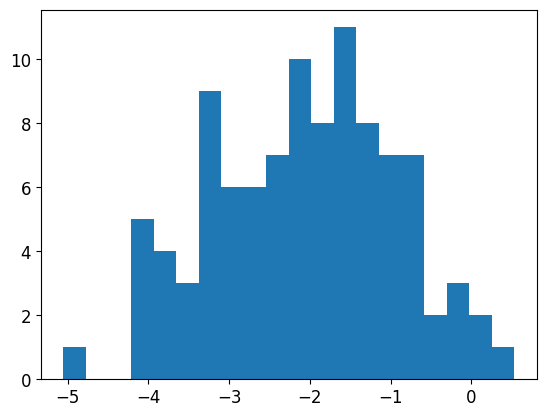

In [141]:
plt.hist([float(c) for c in jnp.log(jnp.array(res_rbf)/postprocess(res_ours))/jnp.log(2)], bins=20)

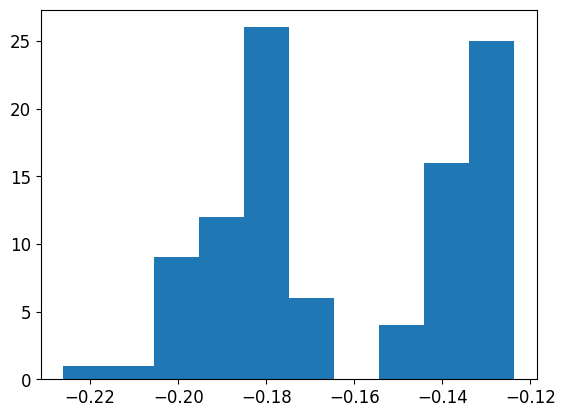

In [142]:
plt.hist(postprocess(res_cfd) - postprocess(res_ours))
plt.show()

(array([ 1.,  0.,  2.,  1.,  7.,  2.,  9.,  6., 17.,  6.,  3.,  1.,  0.,
         1.,  2.,  2.,  7., 14.,  8., 11.]),
 array([-0.65297832, -0.62250619, -0.59203406, -0.56156193, -0.53108979,
        -0.50061766, -0.47014553, -0.4396734 , -0.40920127, -0.37872913,
        -0.348257  , -0.31778487, -0.28731274, -0.25684061, -0.22636847,
        -0.19589634, -0.16542421, -0.13495208, -0.10447994, -0.07400781,
        -0.04353568]),
 <BarContainer object of 20 artists>)

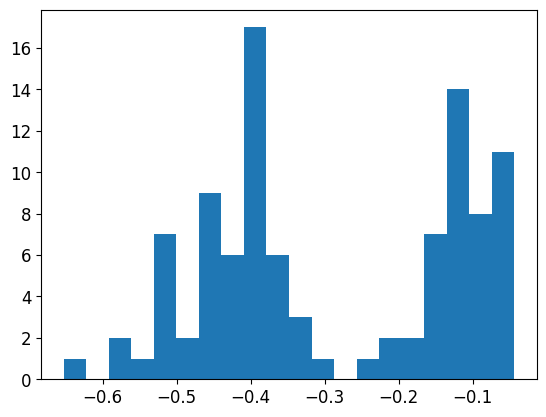

In [143]:
plt.hist([float(c) for c in jnp.log(postprocess(res_fd)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  0.,  1.,  2.,  5.,  4., 10., 10., 15.,  4.,  3.,  0.,  0.,
         1.,  2.,  1.,  6., 16.,  9., 10.]),
 array([-2.07490592, -2.04464826, -2.01439059, -1.98413293, -1.95387527,
        -1.9236176 , -1.89335994, -1.86310227, -1.83284461, -1.80258695,
        -1.77232928, -1.74207162, -1.71181395, -1.68155629, -1.65129863,
        -1.62104096, -1.5907833 , -1.56052563, -1.53026797, -1.50001031,
        -1.46975264]),
 <BarContainer object of 20 artists>)

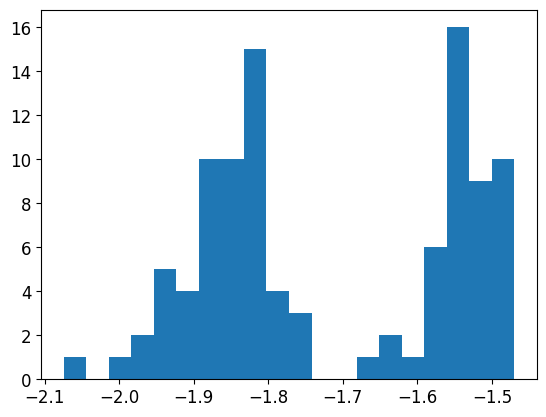

In [144]:
plt.hist([float(c) for c in jnp.log(postprocess(res_cfd)/postprocess(res_ours))/jnp.log(2)], bins=20)

# Cutest hopes

In [145]:
from Functions import Ackley

In [149]:
dim = 32 
sig = 1e-3




prmts_0 = jnp.zeros(dim)

F = Ackley()
F_tilde = Ackley(sig)
            

prct_bound = 0.2 # we look at a neighborhood of +/- p%. 
fixed_bound = 1
jrandom_key = jrandom.PRNGKey(0)




In [151]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([F], prmts_0, N_pts, prct_bound, subkey, fixed_bound=fixed_bound, smoothing=0)
    

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1011.40it/s]


In [153]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e2)
pts = prmts_0.reshape(1, len(prmts_0)) + fixed_bound*(jrandom.uniform(subkey, shape=(N_pts, len(prmts_0))) - 0.5)*2
h_space = jnp.logspace(-1, -6, 6)

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(F, F_tilde, sig, pts, rbfs[0], h_space, subkey, num_runs=1)




100%|█████████████████████████████████████████| 100/100 [02:38<00:00,  1.58s/it]


(array([ 1.,  0.,  0.,  2.,  2.,  3.,  1.,  5.,  7.,  6.,  6., 16.,  9.,
        13., 10.,  5., 11.,  2.,  0.,  1.]),
 array([1.8559919 , 1.94073331, 2.02547472, 2.11021613, 2.19495754,
        2.27969895, 2.36444036, 2.44918177, 2.53392318, 2.61866459,
        2.703406  , 2.78814742, 2.87288883, 2.95763024, 3.04237165,
        3.12711306, 3.21185447, 3.29659588, 3.38133729, 3.4660787 ,
        3.55082011]),
 <BarContainer object of 20 artists>)

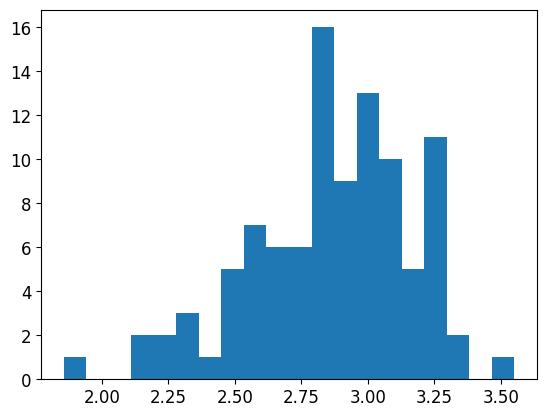

In [154]:
plt.hist([float(c) for c in jnp.log(jnp.array(res_rbf)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  0.,  0.,  2.,  4.,  4., 11.,  5.,  8.,  8.,  6.,  8.,  5.,
         5., 10.,  9.,  4.,  4.,  4.,  2.]),
 array([0.66570789, 0.7208679 , 0.77602791, 0.83118792, 0.88634793,
        0.94150794, 0.99666795, 1.05182796, 1.10698797, 1.16214798,
        1.21730799, 1.272468  , 1.32762801, 1.38278802, 1.43794803,
        1.49310804, 1.54826806, 1.60342807, 1.65858808, 1.71374809,
        1.7689081 ]),
 <BarContainer object of 20 artists>)

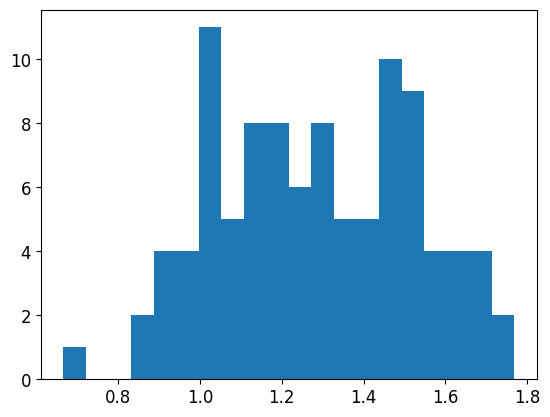

In [155]:
plt.hist([float(c) for c in jnp.log(postprocess(res_fd)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  1.,  3.,  1.,  0.,  3.,  5.,  4.,  7.,  6.,  7., 12.,  9.,
         6.,  7.,  8.,  8.,  5.,  5.,  2.]),
 array([-1.43231835, -1.37076145, -1.30920456, -1.24764766, -1.18609077,
        -1.12453387, -1.06297698, -1.00142008, -0.93986319, -0.87830629,
        -0.81674939, -0.7551925 , -0.6936356 , -0.63207871, -0.57052181,
        -0.50896492, -0.44740802, -0.38585113, -0.32429423, -0.26273734,
        -0.20118044]),
 <BarContainer object of 20 artists>)

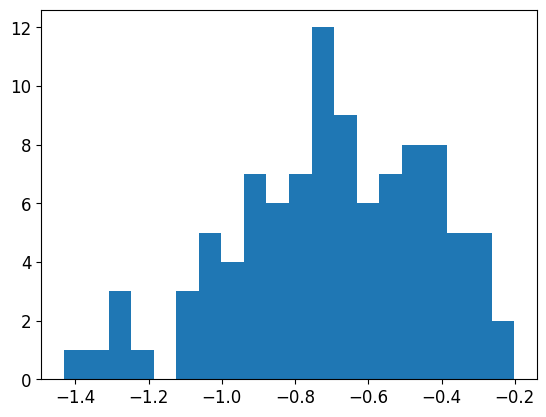

In [156]:
plt.hist([float(c) for c in jnp.log(postprocess(res_cfd)/postprocess(res_ours))/jnp.log(2)], bins=20)

# Cancer

In [160]:
a1 = 0.1
a2 = 0.3
a3 = 0.69
b1 = 0.1
b2 = 0.3
b3 = 0.397
gamma = 0.139
k0 = 0.1
m0 = 0.1
k1 = 0.0003
m1 = 0.0004

final_T = 100
dt = 0.01

x_init = 1
y_init = 100
z_init = 100

prmts_0 = jnp.array([a1, a2, a3, b1, b2, b3, gamma, k0, m0, k1, m1])

Fs = [Cancer(x_init, y_init, z_init, dt, final_T, sig=0, output_var="N0"),
      Cancer(x_init, y_init, z_init, dt, final_T, sig=0, output_var="N1"),
      Cancer(x_init, y_init, z_init, dt, final_T, sig=0, output_var="N2")]

sig = 1e-3
Fs_tilde = [Cancer(x_init, y_init, z_init, dt, final_T, sig=sig, output_var="N0"),
            Cancer(x_init, y_init, z_init, dt, final_T, sig=sig, output_var="N1"),
            Cancer(x_init, y_init, z_init, dt, final_T, sig=sig, output_var="N2")]
            

prct_bound = 0.1 # we look at a neighborhood of +/- p%. 
jrandom_key = jrandom.PRNGKey(0)




In [163]:
jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)

N_pts = int(1e4)
rbfs = get_rbfs([Fs[0]], prmts_0, N_pts, prct_bound, subkey, smoothing=0)
    

100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 4181.73it/s]


In [192]:
jrandom_key = jrandom.PRNGKey(2)
jrandom_key, subkey = jrandom.split(jrandom_key)
# sample from uniform distribution
N_pts = int(1e2)
pts_prct = prct_bound*(jrandom.uniform(subkey, shape=(N_pts, len(prmts_0))) - 0.5)*2
pts = prmts_0.reshape(1, len(prmts_0))*(1 + pts_prct)
h_space = jnp.logspace(-2, -3.5, 6)
true_h = 1e-11

jrandom_key, subkey = jrandom.split(jrandom_key)
res_fd, res_cfd, res_ours, res_rbf = mse_sensitivity(Fs[0], Fs_tilde[0], sig, pts, rbfs[0], h_space, subkey, true_h=true_h, num_runs=10)




100%|█████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


(array([ 2., 11., 15., 24., 11.,  5., 10.,  4.,  3.,  4.,  2.,  0.,  0.,
         1.,  3.,  2.,  1.,  0.,  0.,  2.]),
 array([0.62676629, 0.74354731, 0.86032833, 0.97710935, 1.09389037,
        1.21067139, 1.32745241, 1.44423344, 1.56101446, 1.67779548,
        1.7945765 , 1.91135752, 2.02813854, 2.14491956, 2.26170058,
        2.3784816 , 2.49526262, 2.61204364, 2.72882466, 2.84560568,
        2.9623867 ]),
 <BarContainer object of 20 artists>)

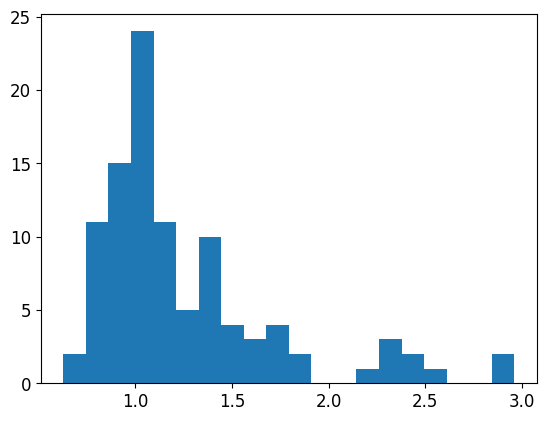

In [193]:
plt.hist([float(c) for c in jnp.log(jnp.array(res_rbf)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  0.,  2.,  0.,  0.,  1.,  1.,  2.,  8.,  6.,  8., 12., 10.,
        13., 18.,  5.,  6.,  5.,  1.,  1.]),
 array([0.9284893 , 0.99147442, 1.05445954, 1.11744467, 1.18042979,
        1.24341492, 1.30640004, 1.36938516, 1.43237029, 1.49535541,
        1.55834053, 1.62132566, 1.68431078, 1.7472959 , 1.81028103,
        1.87326615, 1.93625128, 1.9992364 , 2.06222152, 2.12520665,
        2.18819177]),
 <BarContainer object of 20 artists>)

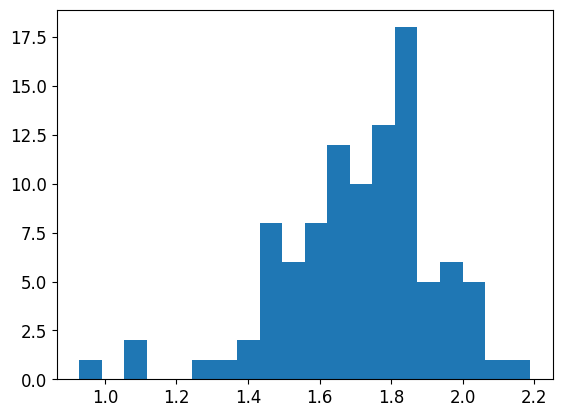

In [194]:
plt.hist([float(c) for c in jnp.log(postprocess(res_fd)/postprocess(res_ours))/jnp.log(2)], bins=20)

(array([ 1.,  2.,  0.,  0.,  0.,  1.,  5.,  4.,  3.,  8., 11., 17., 10.,
        19.,  9.,  7.,  1.,  0.,  1.,  1.]),
 array([-0.99096636, -0.92977127, -0.86857617, -0.80738108, -0.74618599,
        -0.68499089, -0.6237958 , -0.5626007 , -0.50140561, -0.44021051,
        -0.37901542, -0.31782032, -0.25662523, -0.19543013, -0.13423504,
        -0.07303994, -0.01184485,  0.04935025,  0.11054534,  0.17174043,
         0.23293553]),
 <BarContainer object of 20 artists>)

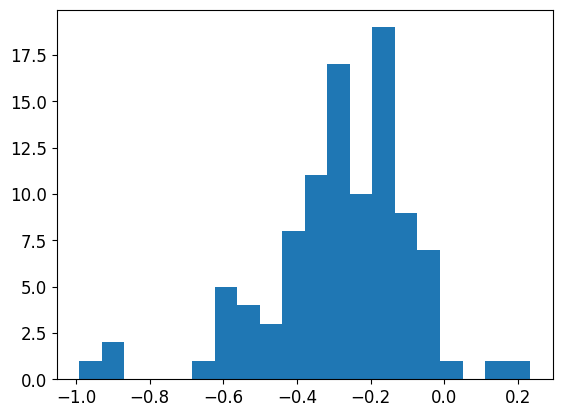

In [195]:
plt.hist([float(c) for c in jnp.log(postprocess(res_cfd)/postprocess(res_ours))/jnp.log(2)], bins=20)